In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates ## Formatear las fechas en el eje x para mostrar solo horas, minutos y segundos
import os
from datetime import datetime, timedelta, time
from sklearn.preprocessing import StandardScaler

## Data

In [21]:
# Se crea un diccionario para almacenar los marcos de datos.
dataframes = {}

data_folder = os.path.join('..','Date') #creamos el path

#verificamos que el path sea correcto y en caso que asi sea, vemos los nombres de archivos dentro
if os.path.isdir(data_folder):
    files = os.listdir(data_folder) # guardamos la lista
    print(files)

# Se define una función para leer cada archivo y convertirlo en un dataframe
def read_file(filename):
    df = pd.read_excel(os.path.join(data_folder,filename))
    dataframes[filename] = df #Se crea un elemento del diccionario -> dataframa[CLAVE] = VALOR

#Leo todos los archivos excel
for filename in files:
    read_file(filename)

['Medicion 01-12-2023.xlsx', 'Medicion 02-03-2024.xlsx', 'Medicion 11-03-2024.xlsx', 'Medicion 11-03.xlsx', 'Medicion 15-12-2023.xlsx', 'Medicion 19-04.xlsx', 'Medicion 22-04-2024.xlsx', 'Medicion 23-04-2024.xlsx', 'Medicion 27-05.xlsx', 'Medicion 28-05.xlsx', 'Medicion 28-12-2023.xlsx', 'Medicion 29-04-2024.xlsx', 'Medicion 30-04-2024.xlsx']


In [22]:
# Lista para almacenar los DataFrames de Temperaturas
df_list = []
# Lista para almacenar los DataFrames de DateTime
df_date_list = []

for filename in files:
    # Suponiendo que tienes un DataFrame llamado dataframes y un nombre de archivo filename
    # Primero, convierte la columna "Date" en datetime
    dataframes[filename]['Date'] = pd.to_datetime(dataframes[filename]['Date'], errors='coerce')
    # Elimino las filas con NaT en la columna "Date" como referencia.
    dataframes[filename] = dataframes[filename].dropna(subset=['Date'])
    #dataframes[filename] = dataframes[filename].dropna(subset=['T1grasa'])
    # Selecciono las columnas 3 a 11, columnas de temperaturas. Lo guardo en un nuevo datafrema df.
    df = dataframes[filename].iloc[:, 3:12]
    #Sustituyo la columna "Date"(fecha) por una columna datetime donde tengo la fecha y hora.
    dataframes[filename]["Date"]=pd.to_datetime(dataframes[filename]["Date"].dt.strftime('%Y-%m-%d') + ' ' + dataframes[filename]["Time"].astype(str))
    #Inserto la clumna Date en el dataframe df. No utiilio df["Date"]=valor porque este me inserta la columna al final
    df_date = dataframes[filename]["Date"]
     # Agregar el DataFrame a la lista de DataFrame Temperaturas
    df_list.append(df)
    # Agregar el DataFrame a la lista de DataFrame DateTimes
    df_date_list.append(df_date)

In [23]:
#Acoto los datos a 325
num_dato = 300
for i, df in enumerate(df_list):
    df_list[i] = df[:num_dato]
    df_list[i] = df_list[i].bfill() #remplazo los valores nan por el siguiente
    df_date_list[i] = df_date_list[i][:num_dato]

C:\Users\angel\AppData\Local\Temp\ipykernel_8640\3182168096.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_list[i] = df_list[i].bfill() #remplazo los valores nan por el siguiente


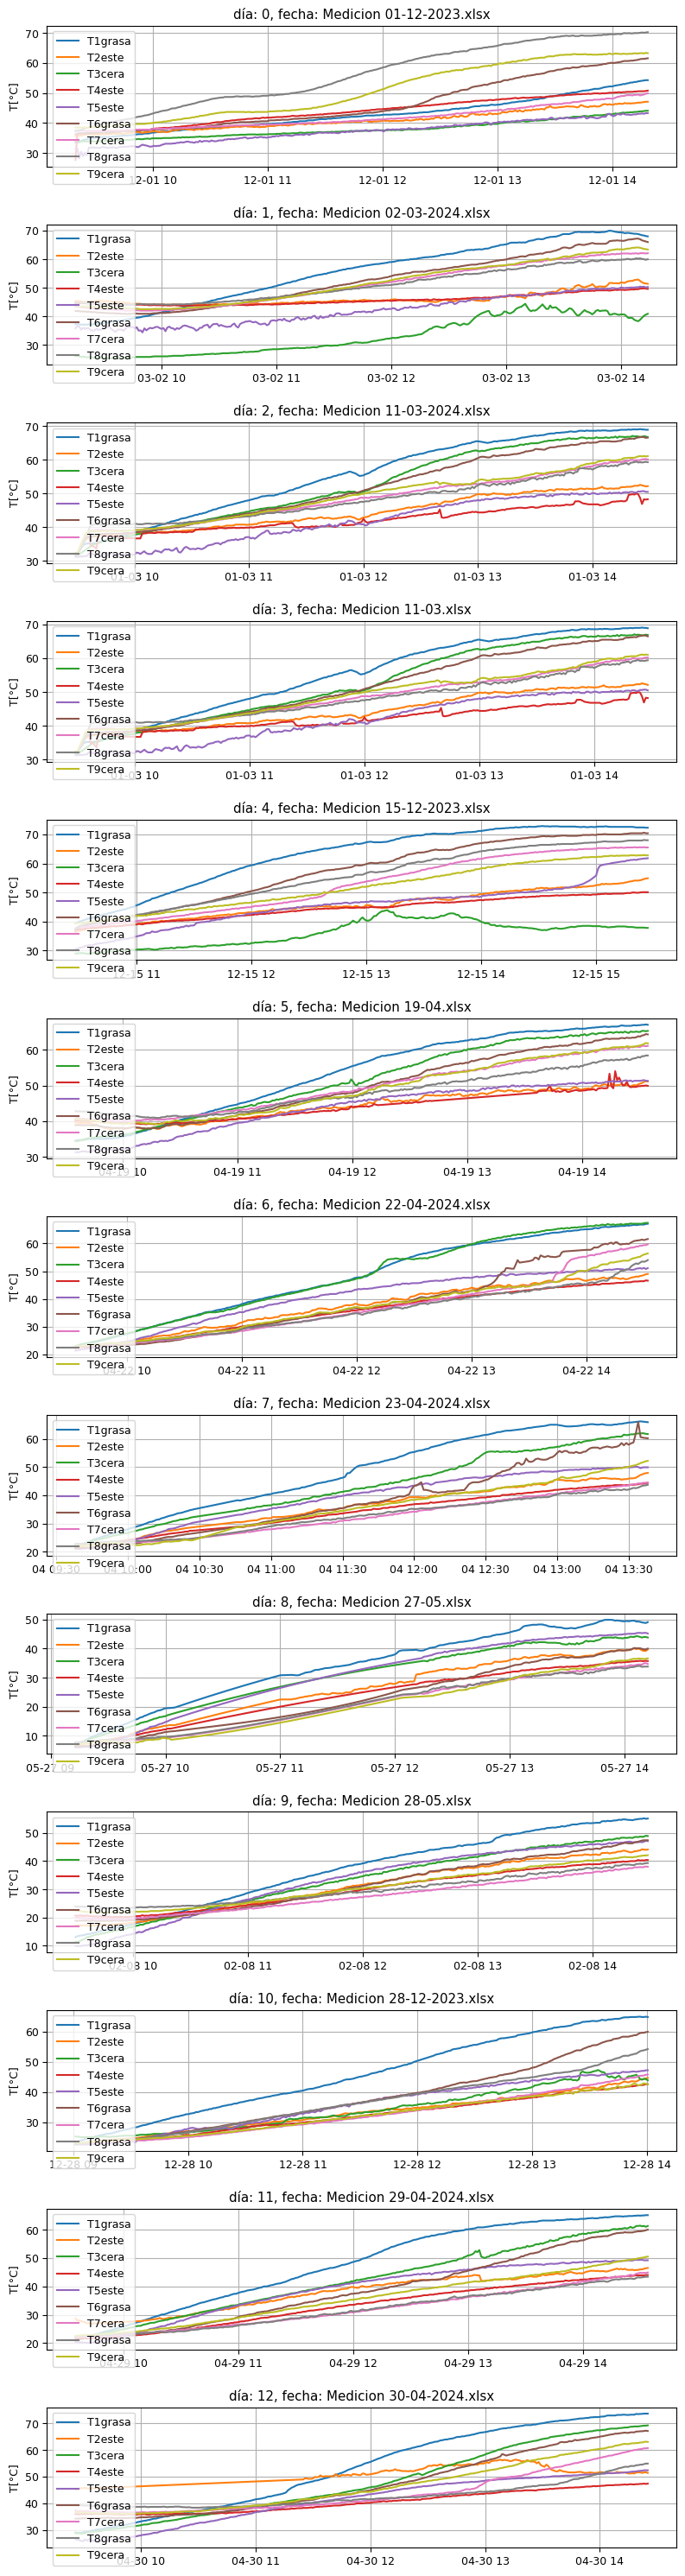

In [24]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 9}
plt.rc('font', **font)
df_columns = df_list[0].columns

fig, axs = plt.subplots(len(df_list),1, figsize=(8,30))
for i, df in enumerate(df_list): 
    axs[i].plot(df_date_list[i],df, '-', label = df.columns)
    axs[i].set_title(f"día: {i}, fecha: {files[i]}")
    axs[i].set_ylabel("T[°C]")
    axs[i].legend(loc = 'upper left')
    axs[i].grid()
fig.tight_layout()
plt.show()

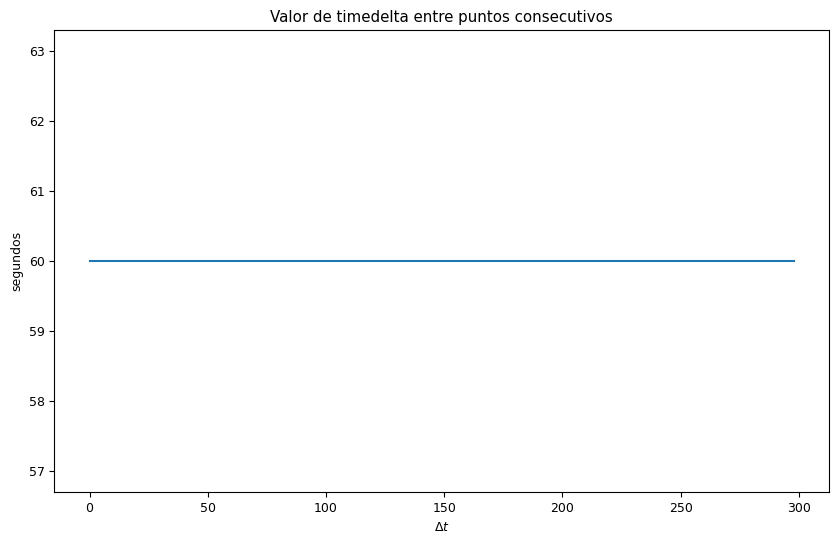

In [25]:
# verificamos que los datos estén completos
dt = np.array(df_date_list[1][1:], dtype = object)-np.array(df_date_list[1][:-1], dtype = object) 
#vector de deltas t. Diferencia del valor anterior con el siguiente.
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title('Valor de timedelta entre puntos consecutivos')
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('segundos')
ax.plot([d.total_seconds() for d in dt]) 

Viendo la grafiaca, $\Delta t$ vale 60 seg. Es decir, se registra las variables cada una hora. Hay que corregir algunos dias, en los que los $\Delta t$ no son constantes.

## Acondicionando los datos

Como las diferentes series no tienen valores similares, es preciso normalizarlas de alguna manera para que la red neuronal las pese por igual a todas. Para ello vamos a utilizar las herramientas que proporciona Sci-Kit Learn.

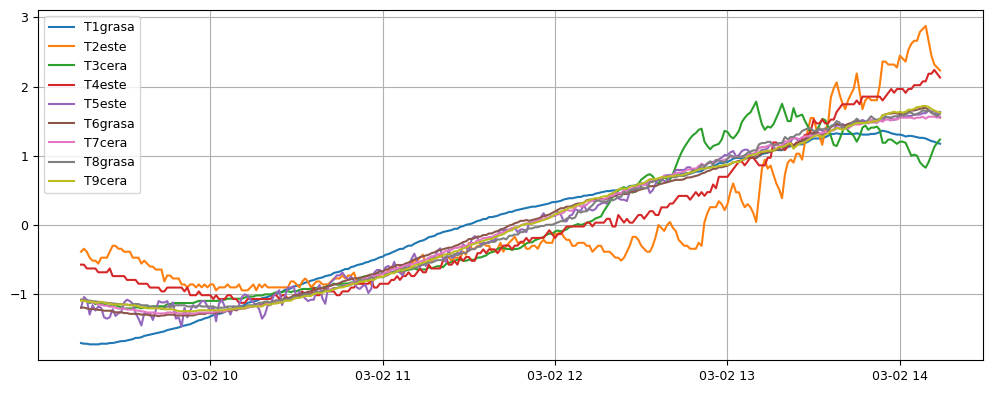

In [26]:
#a todos los datos sacale las medias x' = (x-mu)/sigma
scaler = StandardScaler() 
data = scaler.fit_transform(df_list[1])
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(df_date_list[1], data, label = df_list[1].columns)
ax.legend()
ax.grid()
fig.tight_layout()

In [27]:
# Vamos a separar todo el dataset en una parte de entrenamiento y otra de validacion
from sklearn.model_selection import train_test_split
train, valid = train_test_split(data,test_size=0.2)
print(train.shape, valid.shape)

(240, 9) (60, 9)


## Dataset y Dataloader

Vamos a crear un dataset para el ejercicio 1. Tomaremos una serie de datos previos (lookback = ventana de timepo), para predecir los datos futuros

In [21]:
class Dataset_delayed(torch.utils.data.Dataset):
    # constructor
    def __init__(self, data, lookback = 1):
        self.data = data
        self.lookback = lookback
        # partimos los datos en series con lookback
        self._split_X_Y()
        # convertimos los vectores de NumPy en tensores de PyTorch
        self.X = torch.from_numpy(self.X).float()
        self.Y = torch.from_numpy(self.Y).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def _split_X_Y(self):
        self.X = []
        self.Y = []
        for i in range(self.data.shape[0]-self.lookback):
            self.X.append(self.data[i:i+self.lookback, :].flatten()) # Flatten reduce todo el vector a 1D
            self.Y.append(self.data[i+self.lookback,:])
        #Convierto la lista en array.
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)

### Ejemplo
Supongamos que data es una matriz 2D con las siguientes dimensiones: (100, 3) y lookback es 5. Esto significa que:

self.X tendrá la forma (95, 15) porque cada ventana de 5 datos con 3 características cada uno se aplana en un array de 15 elementos.
self.Y tendrá la forma (95, 3) porque es el valor justo después de cada ventana.

el primer ```flatten``` seria algo asi:

$$X = [A_1, B_1, C_1, A_2, B_2, C_2, ...., A_4,B_4, C_4]$$ 

size = 15

mientras que $Y$ es igual a la fila siguiente $Y = [A_5,B_5,C_5]$

In [22]:
# creamos los datasets y dataloaders en un diccionario para manejar mas simple
lookback = 1
dataset = {'train': Dataset_delayed(train, lookback= lookback),
            'valid' : Dataset_delayed(valid, lookback= lookback)}

dataloader = {'train' : torch.utils.data.DataLoader(dataset['train'], batch_size = 32, shuffle= True),
            'valid' : torch.utils.data.DataLoader(dataset['valid'], batch_size = 32, shuffle= False)}

El ```DataLoader``` agrupa los datos en lotes de tamaño batch_size.

En este caso, ```inputs``` y ```targets``` tendrán la forma (32, lookback*3) y (32, 3) respectivamente, porque solo procesamos 32 muestras a la vez. serian como 32 ```self.X``` de (1, 15) Y como salida tenemos 32 ```self.Y``` de (1,3)reséctivamente (suponiendo que estamos hablando del ejemplo de un dataset de (100,3)).

* Batch size controla cuántas muestras se procesan simultáneamente en cada paso de entrenamiento.
* En nuestro ejemplo, el DataLoader agrupa las secuencias de entrada y sus correspondientes objetivos en lotes de tamaño 32, excepto el último lote que puede ser más pequeño.
* Esto mejora la eficiencia del entrenamiento y permite el uso de aceleradores como GPUs más eficazmente.

## Creación de la NN

Ahora es importante notar que el numero de entradas va a ser igual a la cantidad de variables, es decir:

n_features_in = n_maginudes * lookback 

In [23]:
class Multivariado_MLP(torch.nn.Module):
    def __init__(self, n_in , n_hidden, n_out) -> None:
        super(Multivariado_MLP,self).__init__()

        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.linear_1  = torch.nn.Linear(n_in, n_hidden)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(n_hidden, n_out)
    
    def forward(self, x):
        x1 = self.linear_1(x)
        x2 = self.relu(x1)
        x3 = self.linear_2(x2)
        return x3

## Función de entrenamiento

In [24]:
n_magn = 4 #cantidad de magnitudes
#el lookback en teoría es de 
mlp = Multivariado_MLP(n_magn*lookback, 128, n_magn)

def fit(model, dataloader, epochs = 10):
    '''
    Funcion para entrenar el modelo model utilizando un dataloader
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
    criterion = torch.nn.MSELoss()
    history = []
    for epoch in range(1,epochs+1):
        model.train()   # ponemos el modelo para ser entrenado
        train_h = [] 
        
        # leer los datos en el dataloader es muy simple (recorrera por batches)! 
        for x_b, y_b in dataloader['train']:

            # ponemos los gradientes a cero
            optimizer.zero_grad()
            
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)

            # calculamos los gradientes
            loss.backward()
            
            # actualizamos todos los pesos
            optimizer.step()
            train_h.append(loss.item())

        model.eval() # no estamos entrenando
        test_h = [] 
        with torch.no_grad():  # no vamos a hacer backward, solo ver la metrica sobre el test
            for x_b, y_b in dataloader['valid']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                test_h.append(loss.item())
        if (epoch%10 == 0):
            print(f'epoch: {epoch}/{epochs} - train loss: {np.mean(train_h)} - valid loss: {np.mean(test_h)}')                
        history.append([np.mean(train_h), np.mean(test_h)])
    return history


Divido los datos para entrenamiento y evaluación

In [ ]:
train_data, eval_data = train_test_split(data, test_size = 0.3, shuffle = False) #70% de entrenamiento

In [ ]:
class Preprocessor:
    def __init__(self, tstamps, data, lookback):
        self.data = data
        self.split_train_test_valid() #separacion de datos
        self.create_fit_scaler() #Scaler

    def split_train_test_valid(self):
        # split en train, test y valid
        self.train_t, self.test_t = train_test_split(self.tstamps, test_size=0.3, shuffle= False) # 70% de entrenamiento
        self.train_raw, self.test_raw = train_test_split(self.raw_data, test_size=0.3, shuffle= False)

    def create_fit_scaler(self):
        # Scaling de los datos
        self.scaler = StandardScaler()
        self.train_scaled = self.scaler.fit_transform(self.train_raw)
        self.test_scaled  = self.scaler.transform(self.test_raw)

    def scale_single_sample(self, x):
        return self.scaler.transform(x)
    
    def inverse_scale_single_sample(self,x):
        return self.scaler.inverse_transform(x)